## 🔧 Instalación de Dependencias

In [1]:
# Instalación de dependencias necesarias
!pip install torch numpy pandas scikit-learn tqdm matplotlib seaborn kagglehub psutil

# Imports principales
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import psutil
import kagglehub
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("✅ Dependencias instaladas y configuradas correctamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## 📊 Carga del Dataset

🎯 CARGANDO DATOS CON PARÁMETROS:
   min_seq_len=3, max_seq_len=50, min_item_freq=5
🔄 Descargando dataset RetailRocket...


100%|██████████| 291M/291M [00:14<00:00, 21.2MB/s]

Extracting files...


📖 Cargando datos...
📊 Estadísticas iniciales:
   Total interacciones: 2,664,312
   Usuarios únicos: 1,404,179
   Items únicos: 234,838
🔧 Creando secuencias de usuario...
📏 Después de filtrar por longitud [3, 50]:
   Secuencias restantes: 189,924
🎯 Filtrando items poco frecuentes...
   Items frecuentes (>=5 apariciones): 44,022
📋 Estadísticas finales:
   Secuencias válidas: 153,745
   Items únicos: 44,022
   Longitud promedio: 5.65
   Longitud mediana: 4


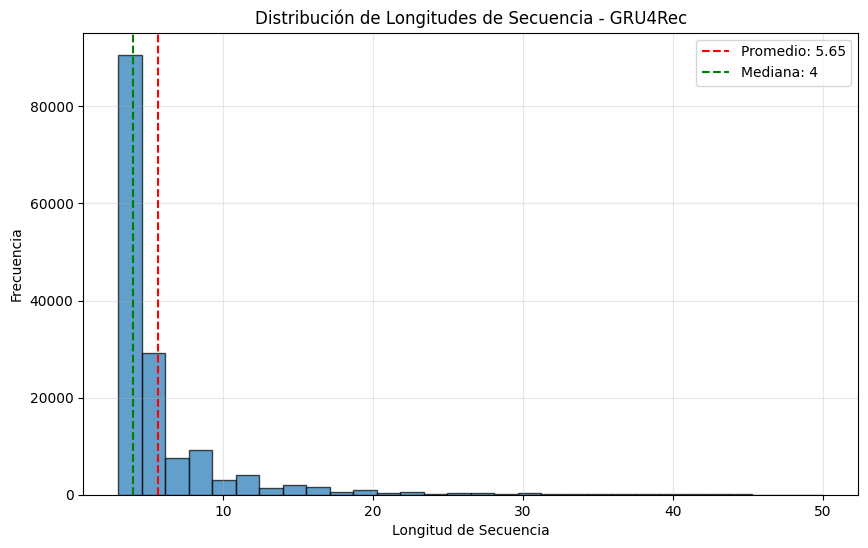

✅ Dataset cargado exitosamente:
   153,745 secuencias
   44,022 items únicos
   Vocabulario size: 44023


In [2]:
def load_and_preprocess_retailrocket(min_seq_len=3, max_seq_len=50, min_item_freq=5):
    """
    Carga y preprocesa el dataset RetailRocket
    """
    print("🔄 Descargando dataset RetailRocket...")

    # Descargar dataset
    path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")
    events_path = os.path.join(path, 'events.csv')

    # Leer y filtrar datos
    print("📖 Cargando datos...")
    df = pd.read_csv(events_path)
    df = df[df['event'] == 'view']  # Solo eventos de visualización
    df = df.sort_values(by=['visitorid', 'timestamp'])

    print(f"📊 Estadísticas iniciales:")
    print(f"   Total interacciones: {len(df):,}")
    print(f"   Usuarios únicos: {df['visitorid'].nunique():,}")
    print(f"   Items únicos: {df['itemid'].nunique():,}")

    # Crear secuencias por usuario
    print("🔧 Creando secuencias de usuario...")
    user_sequences = df.groupby('visitorid')['itemid'].apply(list).reset_index()
    user_sequences.columns = ['user_id', 'item_sequence']

    # Filtrar por longitud de secuencia
    user_sequences['seq_len'] = user_sequences['item_sequence'].apply(len)
    filtered_sequences = user_sequences[
        (user_sequences['seq_len'] >= min_seq_len) &
        (user_sequences['seq_len'] <= max_seq_len)
    ]

    print(f"📏 Después de filtrar por longitud [{min_seq_len}, {max_seq_len}]:")
    print(f"   Secuencias restantes: {len(filtered_sequences):,}")

    # Filtrar items poco frecuentes para reducir vocabulario
    print("🎯 Filtrando items poco frecuentes...")
    all_items = []
    for seq in filtered_sequences['item_sequence']:
        all_items.extend(seq)

    item_counts = Counter(all_items)
    frequent_items = {item for item, count in item_counts.items() if count >= min_item_freq}

    print(f"   Items frecuentes (>={min_item_freq} apariciones): {len(frequent_items):,}")

    # Filtrar secuencias para mantener solo items frecuentes
    def filter_sequence(seq):
        return [item for item in seq if item in frequent_items]

    filtered_sequences['item_sequence'] = filtered_sequences['item_sequence'].apply(filter_sequence)

    # Remover secuencias que quedaron muy cortas después del filtrado
    filtered_sequences['seq_len'] = filtered_sequences['item_sequence'].apply(len)
    final_sequences = filtered_sequences[filtered_sequences['seq_len'] >= min_seq_len]

    print(f"📋 Estadísticas finales:")
    print(f"   Secuencias válidas: {len(final_sequences):,}")
    print(f"   Items únicos: {len(frequent_items):,}")
    print(f"   Longitud promedio: {final_sequences['seq_len'].mean():.2f}")
    print(f"   Longitud mediana: {final_sequences['seq_len'].median():.0f}")

    # Crear mapeo de items a índices (0 reservado para padding)
    item_to_idx = {item: idx + 1 for idx, item in enumerate(sorted(frequent_items))}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}

    # Convertir secuencias a índices
    sequences_idx = []
    for seq in final_sequences['item_sequence']:
        seq_idx = [item_to_idx[item] for item in seq]
        sequences_idx.append(seq_idx)

    # Estadísticas de distribución
    seq_lengths = [len(seq) for seq in sequences_idx]
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(seq_lengths), color='red', linestyle='--',
                label=f'Promedio: {np.mean(seq_lengths):.2f}')
    plt.axvline(np.median(seq_lengths), color='green', linestyle='--',
                label=f'Mediana: {np.median(seq_lengths):.0f}')
    plt.xlabel('Longitud de Secuencia')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Longitudes de Secuencia - GRU4Rec')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return sequences_idx, item_to_idx, idx_to_item

# Cargar y preprocesar datos
print("🎯 CARGANDO DATOS CON PARÁMETROS:")
print("   min_seq_len=3, max_seq_len=50, min_item_freq=5")

sequences, item_to_idx, idx_to_item = load_and_preprocess_retailrocket(
    min_seq_len=3,
    max_seq_len=50,
    min_item_freq=5
)

print(f"✅ Dataset cargado exitosamente:")
print(f"   {len(sequences):,} secuencias")
print(f"   {len(item_to_idx):,} items únicos")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding


## 🔄 División del Dataset

In [3]:
# CLASE DATASET
class SequentialDataset(Dataset):
    """Dataset optimizado para secuencias con padding dinámico"""

    def __init__(self, sequences, max_len=50):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Crear input y target sequences
        if len(seq) <= self.max_len:
            # Secuencia completa
            input_seq = seq[:-1]  # Todos menos el último
            target_seq = seq[1:]  # Todos menos el primero
        else:
            # Truncar secuencia
            input_seq = seq[:self.max_len]
            target_seq = seq[1:self.max_len+1]

        # Padding
        input_padded = [0] * (self.max_len - len(input_seq)) + input_seq
        target_padded = [0] * (self.max_len - len(target_seq)) + target_seq

        return torch.tensor(input_padded, dtype=torch.long), torch.tensor(target_padded, dtype=torch.long)

# DIVISIÓN (misma semilla random_state=42)
print("🎯 DIVIDIENDO DATASET CON SEMILLA (random_state=42)")
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

print(f"📊 División del dataset:")
print(f"   Entrenamiento: {len(train_sequences):,} secuencias")
print(f"   Prueba: {len(test_sequences):,} secuencias")

# CÁLCULO IDÉNTICO DE MAX_LEN
all_lengths = [len(seq) for seq in sequences]
max_len_95 = int(np.percentile(all_lengths, 95))
max_len_99 = int(np.percentile(all_lengths, 99))

print(f"📏 Análisis de longitudes:")
print(f"   Máximo: {max(all_lengths)}")
print(f"   Percentil 95: {max_len_95}")
print(f"   Percentil 99: {max_len_99}")

# USAR MISMO MAX_LEN
MAX_LEN = max_len_95
print(f"   Usando max_len = {MAX_LEN}")

# CREAR DATASETS IDÉNTICOS
train_dataset = SequentialDataset(train_sequences, max_len=MAX_LEN)
test_dataset = SequentialDataset(test_sequences, max_len=MAX_LEN)

# CREAR DATALOADERS CON MISMO BATCH_SIZE
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de prueba: {len(test_loader)}")
print(f"   Max length: {MAX_LEN}")

# VERIFICAR QUE LOS DATOS SON IDÉNTICOS
sample_input, sample_target = next(iter(train_loader))
print(f"\n📝 Ejemplo de batch:")
print(f"   Input shape: {sample_input.shape}")
print(f"   Target shape: {sample_target.shape}")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding

print(f"\n🔍 VERIFICACIÓN DE IDENTIDAD:")
print(f"   ✅ Mismos filtros de preprocesamiento")
print(f"   ✅ Misma división train/test (random_state=42)")
print(f"   ✅ Mismo max_len ({MAX_LEN})")
print(f"   ✅ Mismo batch_size ({BATCH_SIZE})")
print(f"   ✅ Mismo vocabulario ({len(item_to_idx) + 1} items)")
print(f"   ✅ Mismas secuencias de datos")


🎯 DIVIDIENDO DATASET CON SEMILLA (random_state=42)
📊 División del dataset:
   Entrenamiento: 122,996 secuencias
   Prueba: 30,749 secuencias
📏 Análisis de longitudes:
   Máximo: 50
   Percentil 95: 14
   Percentil 99: 28
   Usando max_len = 14
✅ DataLoaders creados:
   Batch size: 32
   Batches de entrenamiento: 3844
   Batches de prueba: 961
   Max length: 14

📝 Ejemplo de batch:
   Input shape: torch.Size([32, 14])
   Target shape: torch.Size([32, 14])
   Vocabulario size: 44023

🔍 VERIFICACIÓN DE IDENTIDAD:
   ✅ Mismos filtros de preprocesamiento
   ✅ Misma división train/test (random_state=42)
   ✅ Mismo max_len (14)
   ✅ Mismo batch_size (32)
   ✅ Mismo vocabulario (44023 items)
   ✅ Mismas secuencias de datos


## 🧠 Implementación de GRU4Rec

GRU4Rec utiliza Gated Recurrent Units (GRU) para modelar secuencias de ítems en sistemas de recomendación, siendo especialmente efectivo para recomendaciones basadas en sesiones.

In [4]:
class GRU4Rec(nn.Module):
    """
    GRU4Rec: Session-based Recommendations with Recurrent Neural Networks

    Implementación optimizada de GRU4Rec
    """

    def __init__(self, num_items, embedding_dim=64, hidden_dim=128, num_layers=1, dropout=0.1):
        super(GRU4Rec, self).__init__()

        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer para items
        self.item_embedding = nn.Embedding(num_items, embedding_dim, padding_idx=0)

        # GRU layers
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Output projection layer
        self.output_projection = nn.Linear(hidden_dim, num_items)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize model weights siguiendo las mejores prácticas"""
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.01)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].fill_(0)
            elif isinstance(module, nn.GRU):
                for name, param in module.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        """
        Forward pass

        Args:
            x: Input tensor of shape (batch_size, seq_len)

        Returns:
            Output tensor of shape (batch_size, seq_len, num_items)
        """
        # Embedding
        embedded = self.item_embedding(x)  # (batch_size, seq_len, embedding_dim)

        # GRU forward pass
        gru_output, _ = self.gru(embedded)  # (batch_size, seq_len, hidden_dim)

        # Apply dropout
        gru_output = self.dropout(gru_output)

        # Project to item space
        output = self.output_projection(gru_output)  # (batch_size, seq_len, num_items)

        return output

# Crear modelo GRU4Rec
VOCAB_SIZE = len(item_to_idx) + 1  # +1 para padding
EMBEDDING_DIM = 64
HIDDEN_DIM = 128    # Tamaño típico para GRU4Rec
NUM_LAYERS = 1      # Empezar con 1 capa
DROPOUT = 0.1

model = GRU4Rec(
    num_items=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Mostrar arquitectura del modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🏗️  Arquitectura de GRU4Rec:")
print(f"   Vocabulario: {VOCAB_SIZE:,} items")
print(f"   Embedding dim: {EMBEDDING_DIM}")
print(f"   Hidden dim: {HIDDEN_DIM}")
print(f"   Número de capas GRU: {NUM_LAYERS}")
print(f"   Dropout: {DROPOUT}")
print(f"   Parámetros totales: {total_params:,}")
print(f"   Parámetros entrenables: {trainable_params:,}")

# Probar forward pass
with torch.no_grad():
    sample_input = sample_input.to(device)
    sample_output = model(sample_input)
    print(f"\n✅ Forward pass exitoso:")
    print(f"   Input shape: {sample_input.shape}")
    print(f"   Output shape: {sample_output.shape}")
    print(f"   Memoria GPU usada: {torch.cuda.memory_allocated(device) / 1024**2:.1f} MB" if torch.cuda.is_available() else "   CPU usado")


🏗️  Arquitectura de GRU4Rec:
   Vocabulario: 44,023 items
   Embedding dim: 64
   Hidden dim: 128
   Número de capas GRU: 1
   Dropout: 0.1
   Parámetros totales: 8,570,935
   Parámetros entrenables: 8,570,935

✅ Forward pass exitoso:
   Input shape: torch.Size([32, 14])
   Output shape: torch.Size([32, 14, 44023])
   Memoria GPU usada: 117.3 MB


## 🚀 Entrenamiento de GRU4Rec

🚀 Iniciando entrenamiento de GRU4Rec...
   Epochs: 10
   Learning rate: 0.001
   Batches por epoch: 3844


Epoch 1/10: 100%|██████████| 3844/3844 [00:54<00:00, 70.85it/s, Loss=9.5129, Avg Loss=9.8178]


   Epoch 1/10 completado - Loss: 9.8178


Epoch 2/10: 100%|██████████| 3844/3844 [00:53<00:00, 72.10it/s, Loss=7.8009, Avg Loss=8.2074]


   Epoch 2/10 completado - Loss: 8.2074


Epoch 3/10: 100%|██████████| 3844/3844 [00:52<00:00, 73.32it/s, Loss=6.6145, Avg Loss=6.7057]


   Epoch 3/10 completado - Loss: 6.7057


Epoch 4/10: 100%|██████████| 3844/3844 [00:52<00:00, 73.60it/s, Loss=5.7978, Avg Loss=5.6065]


   Epoch 4/10 completado - Loss: 5.6065


Epoch 5/10: 100%|██████████| 3844/3844 [00:52<00:00, 72.69it/s, Loss=5.2952, Avg Loss=4.8061]


   Epoch 5/10 completado - Loss: 4.8061


Epoch 6/10: 100%|██████████| 3844/3844 [00:53<00:00, 72.29it/s, Loss=3.9312, Avg Loss=4.2212]


   Epoch 6/10 completado - Loss: 4.2212


Epoch 7/10: 100%|██████████| 3844/3844 [00:53<00:00, 71.21it/s, Loss=3.1491, Avg Loss=3.7746]


   Epoch 7/10 completado - Loss: 3.7746


Epoch 8/10: 100%|██████████| 3844/3844 [00:52<00:00, 72.84it/s, Loss=3.9097, Avg Loss=3.4254]


   Epoch 8/10 completado - Loss: 3.4254


Epoch 9/10: 100%|██████████| 3844/3844 [00:52<00:00, 72.93it/s, Loss=3.5469, Avg Loss=3.1445]


   Epoch 9/10 completado - Loss: 3.1445


Epoch 10/10: 100%|██████████| 3844/3844 [00:52<00:00, 73.76it/s, Loss=3.1284, Avg Loss=2.9276]


   Epoch 10/10 completado - Loss: 2.9276


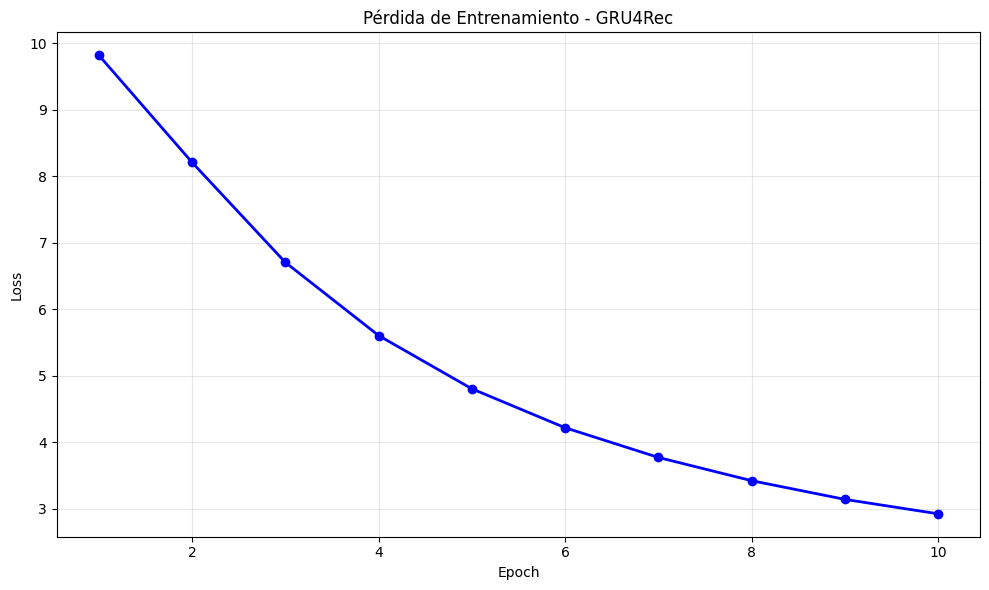

✅ Entrenamiento completado!
   Loss final: 2.9276
   Mejor loss: 2.9276
💾 Modelo guardado como 'gru4rec_retailrocket.pth'


In [5]:
def train_gru4rec(model, train_loader, num_epochs=10, learning_rate=0.001):
    """
    Entrena GRU4Rec
    """
    print(f"🚀 Iniciando entrenamiento de GRU4Rec...")
    print(f"   Epochs: {num_epochs}")
    print(f"   Learning rate: {learning_rate}")
    print(f"   Batches por epoch: {len(train_loader)}")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignorar padding (index 0)

    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.5, patience=2, verbose=True)

    model.train()

    # Listas para tracking
    epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (input_seq, target_seq) in enumerate(progress_bar):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # Forward pass
            optimizer.zero_grad()
            logits = model(input_seq)  # (batch_size, seq_len, vocab_size)

            # Reshape for loss calculation
            logits = logits.reshape(-1, logits.size(-1))  # (batch_size * seq_len, vocab_size)
            target_seq = target_seq.reshape(-1)  # (batch_size * seq_len,)

            # Calculate loss
            loss = criterion(logits, target_seq)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update metrics
            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{total_loss/num_batches:.4f}'
            })

            # Limpieza de memoria
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

        # Métricas del epoch
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)

        print(f"   Epoch {epoch+1}/{num_epochs} completado - Loss: {avg_loss:.4f}")

        # Update scheduler
        scheduler.step(avg_loss)

        # Limpieza de memoria al final del epoch
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Graficar pérdidas de entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, 'b-', linewidth=2, marker='o')
    plt.title('Pérdida de Entrenamiento - GRU4Rec')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"✅ Entrenamiento completado!")
    print(f"   Loss final: {epoch_losses[-1]:.4f}")
    print(f"   Mejor loss: {min(epoch_losses):.4f}")

    return epoch_losses

training_losses = train_gru4rec(
    model=model,
    train_loader=train_loader,
    num_epochs=10,
    learning_rate=0.001
)

# Guardar modelo entrenado
torch.save(model.state_dict(), 'gru4rec_retailrocket.pth')
print("💾 Modelo guardado como 'gru4rec_retailrocket.pth'")


## 📊 Evaluación


In [6]:
# ILD CON FÓRMULA ESTÁNDAR
print("🔧 Función ILD con fórmula estándar...")

def calculate_intra_list_diversity_efficient(recommendations_list, model=None):
    """
    Calcula la Intra-List Diversity (ILD) usando similitud coseno de embeddings

    Fórmula estándar: ILD(L) = (2 / (|L|(|L|-1))) * Σ(i<j) (1 - sim(i,j))

    Args:
        recommendations_list: Lista de listas de items recomendados
        model: Modelo con embeddings

    Returns:
        float: Valor de ILD promedio
    """
    if not recommendations_list:
        return 0.0

    if model is None:
        raise ValueError("Se requiere un modelo con embeddings para calcular ILD")

    # Obtener embeddings del modelo
    if hasattr(model, 'item_embedding'):
        embedding_layer = model.item_embedding
    elif hasattr(model, 'embedding'):
        embedding_layer = model.embedding
    else:
        raise ValueError("Se requiere un modelo con embeddings para calcular ILD")

    print(f"🔍 Calculando ILD con fórmula estándar usando embeddings del modelo...")

    total_diversity = 0.0
    valid_sessions = 0

    with torch.no_grad():
        for rec_list in recommendations_list:
            if len(rec_list) < 2:
                continue

            # Obtener embeddings de los items recomendados
            item_ids = torch.tensor(rec_list, dtype=torch.long)
            if torch.cuda.is_available():
                item_ids = item_ids.cuda()

            # Obtener embeddings (shape: [num_items, embedding_dim])
            embeddings = embedding_layer(item_ids)

            # Calcular similitud coseno entre todos los pares
            # Normalizar embeddings para usar producto punto como coseno
            embeddings_norm = F.normalize(embeddings, p=2, dim=1)

            # Matriz de similitud coseno
            similarity_matrix = torch.mm(embeddings_norm, embeddings_norm.t())

            # Calcular ILD usando la fórmula estándar
            num_items = len(rec_list)
            total_pairs = num_items * (num_items - 1) // 2

            if total_pairs == 0:
                continue

            # Sumar todas las similitudes de pares únicos (i < j)
            similarity_sum = 0.0
            for i in range(num_items):
                for j in range(i + 1, num_items):
                    similarity_sum += similarity_matrix[i, j].item()

            # ILD = (2 / (|L|(|L|-1))) * Σ(i<j) (1 - sim(i,j))
            diversity = (2.0 / (num_items * (num_items - 1))) * (total_pairs - similarity_sum)
            total_diversity += diversity
            valid_sessions += 1

    avg_diversity = total_diversity / valid_sessions if valid_sessions > 0 else 0.0
    print(f"✅ ILD calculado: {avg_diversity:.4f} (usando {valid_sessions} sesiones válidas)")
    return avg_diversity

print("✅ Función ILD actualizada con fórmula estándar")


🔧 Función ILD con fórmula estándar...
✅ Función ILD actualizada con fórmula estándar


In [7]:
# FUNCIONES DE EVALUACIÓN

def evaluate_model_memory_efficient(model, test_loader, train_item_popularity, device,
                                   k_values=[5, 10, 20], max_samples_for_diversity=10000):
    """
    Evaluación optimizada para memoria que calcula métricas on-the-fly
    """
    model.eval()

    # Inicializar contadores para cada k
    metrics = {}
    for k in k_values:
        metrics[k] = {
            'recall_hits': 0,
            'mrr_sum': 0.0,
            'recommendations': [],  # Solo guardamos top-k, no predicciones completas
            'total_predictions': 0
        }

    max_k = max(k_values)
    max_popularity = max(train_item_popularity.values()) if train_item_popularity else 1

    print(f"🔍 Evaluando GRU4Rec (optimizado para memoria)...")
    print(f"   Calculando métricas para k = {k_values}")
    print(f"   Máximo muestras para diversidad: {max_samples_for_diversity:,}")

    with torch.no_grad():
        batch_count = 0
        total_predictions = 0

        for input_seq, target_seq in tqdm(test_loader, desc="Evaluando"):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # Predicciones del modelo
            logits = model(input_seq)  # (batch_size, seq_len, vocab_size)

            # Máscara para posiciones válidas (no padding)
            mask = target_seq != 0

            # Procesar cada secuencia en el batch
            for i in range(logits.size(0)):
                seq_logits = logits[i]  # (seq_len, vocab_size)
                seq_targets = target_seq[i]  # (seq_len,)
                seq_mask = mask[i]  # (seq_len,)

                # Procesar cada posición en la secuencia
                for j in range(seq_logits.size(0)):
                    if seq_mask[j]:  # Si no es padding
                        pred_scores = seq_logits[j]  # (vocab_size,)
                        true_item = seq_targets[j].item()

                        # Obtener top-max_k items (excluyendo padding idx=0)
                        # Evitamos recomendar el padding token
                        valid_scores = pred_scores[1:]  # Excluir padding (índice 0)
                        _, top_k_indices = torch.topk(valid_scores, max_k)
                        top_k_items = (top_k_indices + 1).cpu().tolist()  # +1 porque excluimos índice 0

                        # Calcular métricas para cada k
                        for k in k_values:
                            top_k_subset = top_k_items[:k]

                            # Recall@k y MRR@k
                            if true_item in top_k_subset:
                                metrics[k]['recall_hits'] += 1
                                rank = top_k_subset.index(true_item) + 1
                                metrics[k]['mrr_sum'] += 1.0 / rank

                            # Guardar recomendaciones para diversidad (con límite de memoria)
                            if len(metrics[k]['recommendations']) < max_samples_for_diversity:
                                metrics[k]['recommendations'].append(top_k_subset)

                            metrics[k]['total_predictions'] += 1

                        total_predictions += 1

            # Limpieza periódica de memoria
            batch_count += 1
            if batch_count % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()

    # Calcular métricas finales
    results = {}

    print(f"📊 Calculando métricas finales...")

    for k in k_values:
        total_preds = metrics[k]['total_predictions']

        # Recall@k y MRR@k
        recall_k = metrics[k]['recall_hits'] / total_preds if total_preds > 0 else 0.0
        mrr_k = metrics[k]['mrr_sum'] / total_preds if total_preds > 0 else 0.0

        # ILD (Diversidad) - Versión eficiente
        ild_k = calculate_intra_list_diversity_efficient(metrics[k]['recommendations'], model)

        # Popularity Bias - Versión eficiente
        pop_bias_k = calculate_popularity_bias_efficient(
            metrics[k]['recommendations'],
            train_item_popularity,
            max_popularity
        )

        # Almacenar resultados
        results[f'recall_{k}'] = recall_k
        results[f'mrr_{k}'] = mrr_k
        results[f'ild_{k}'] = ild_k
        results[f'popularity_bias_{k}'] = pop_bias_k

    # Limpieza final
    del metrics
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results

def calculate_popularity_bias_efficient(recommendations_list, item_popularity, max_popularity):
    """
    Calcula el sesgo hacia items populares de forma eficiente
    """
    if not recommendations_list or not item_popularity:
        return 0.0

    total_popularity = 0.0
    total_items = 0

    for rec_list in recommendations_list:
        for item_id in rec_list:
            if item_id in item_popularity:
                normalized_pop = item_popularity[item_id] / max_popularity
                total_popularity += normalized_pop
                total_items += 1

    return total_popularity / total_items if total_items > 0 else 0.0

def monitor_memory_usage():
    """Monitorea el uso actual de memoria"""
    memory = psutil.virtual_memory()
    print(f"💾 MEMORIA DEL SISTEMA:")
    print(f"   Total: {memory.total / (1024**3):.2f} GB")
    print(f"   Usada: {memory.used / (1024**3):.2f} GB ({memory.percent:.1f}%)")
    print(f"   Libre: {memory.available / (1024**3):.2f} GB")

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        gpu_allocated = torch.cuda.memory_allocated(0)
        gpu_cached = torch.cuda.memory_reserved(0)

        print(f"🎮 MEMORIA DE GPU:")
        print(f"   Total: {gpu_memory / (1024**3):.2f} GB")
        print(f"   Asignada: {gpu_allocated / (1024**3):.2f} GB")
        print(f"   En caché: {gpu_cached / (1024**3):.2f} GB")

# Monitorear memoria antes de evaluar
print("🔍 Estado de memoria antes de la evaluación:")
monitor_memory_usage()

print("✅ Funciones de evaluación optimizada cargadas")


🔍 Estado de memoria antes de la evaluación:
💾 MEMORIA DEL SISTEMA:
   Total: 12.67 GB
   Usada: 2.05 GB (18.7%)
   Libre: 10.30 GB
🎮 MEMORIA DE GPU:
   Total: 14.74 GB
   Asignada: 0.15 GB
   En caché: 0.36 GB
✅ Funciones de evaluación optimizada cargadas


In [8]:
# EJECUTAR EVALUACIÓN OPTIMIZADA
print("🚀 Iniciando evaluación completa de GRU4Rec...")

# Calcular popularidad de items del entrenamiento
print("📊 Calculando popularidad de items del entrenamiento...")
train_item_popularity = Counter()
for seq in train_sequences:
    train_item_popularity.update(seq)

print(f"   Items únicos en entrenamiento: {len(train_item_popularity):,}")
print(f"   Item más popular: {max(train_item_popularity.values()):,} apariciones")

# Ejecutar evaluación optimizada CON PARÁMETROS IDÉNTICOS
results = evaluate_model_memory_efficient(
    model=model,
    test_loader=test_loader,
    train_item_popularity=dict(train_item_popularity),
    device=device,
    k_values=[5, 10, 20],
    max_samples_for_diversity=10000
)

# Mostrar resultados completos
print("\n" + "="*70)
print("📋 RESULTADOS COMPLETOS DE GRU4REC - RETAILROCKET")
print("="*70)

print(f"\n🎯 MÉTRICAS DE PRECISIÓN:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Recall':<15} {results['recall_5']:<10.4f} {results['recall_10']:<10.4f} {results['recall_20']:<10.4f}")
print(f"{'MRR':<15} {results['mrr_5']:<10.4f} {results['mrr_10']:<10.4f} {results['mrr_20']:<10.4f}")

print(f"\n🌈 MÉTRICAS DE DIVERSIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'ILD':<15} {results['ild_5']:<10.4f} {results['ild_10']:<10.4f} {results['ild_20']:<10.4f}")

print(f"\n⭐ MÉTRICAS DE SESGO DE POPULARIDAD:")
print(f"{'Métrica':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("-" * 45)
print(f"{'Pop. Bias':<15} {results['popularity_bias_5']:<10.4f} {results['popularity_bias_10']:<10.4f} {results['popularity_bias_20']:<10.4f}")

print(f"\n📈 INTERPRETACIÓN DE RESULTADOS:")
print(f"   🎯 Recall@k: Proporción de items correctos encontrados en top-k")
print(f"      • Valores más altos = mejor precisión")
print(f"      • Típicamente: 0.01-0.20 para datasets reales")
print(f"   ")
print(f"   📊 MRR@k: Posición promedio recíproca de items correctos")
print(f"      • Valores más altos = mejores rankings")
print(f"      • Típicamente: 0.01-0.15 para datasets reales")
print(f"   ")
print(f"   🌈 ILD@k: Diversidad intra-lista (diversidad dentro de cada recomendación)")
print(f"      • Valores más altos = mayor diversidad")
print(f"      • Rango: 0.0-1.0, donde 1.0 = máxima diversidad")
print(f"   ")
print(f"   ⭐ Popularity Bias@k: Sesgo hacia items populares")
print(f"      • Valores más bajos = menos sesgado")
print(f"      • Rango: 0.0-1.0, donde 0.0 = sin sesgo")

# Guardar resultados
import json
with open('../outputs/GRU4Rec_RetailRocket/gru4rec_retailrocket_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n💾 Resultados guardados en '../outputs/GRU4Rec_RetailRocket/gru4rec_retailrocket_results.json'")

# Verificar memoria final
print(f"\n🔍 Estado de memoria después de la evaluación:")
monitor_memory_usage()


🚀 Iniciando evaluación completa de GRU4Rec...
📊 Calculando popularidad de items del entrenamiento...
   Items únicos en entrenamiento: 43,377
   Item más popular: 1,193 apariciones
🔍 Evaluando GRU4Rec (optimizado para memoria)...
   Calculando métricas para k = [5, 10, 20]
   Máximo muestras para diversidad: 10,000


Evaluando: 100%|██████████| 961/961 [00:39<00:00, 24.58it/s]


📊 Calculando métricas finales...
🔍 Calculando ILD con fórmula estándar usando embeddings del modelo...
✅ ILD calculado: 0.5763 (usando 10000 sesiones válidas)
🔍 Calculando ILD con fórmula estándar usando embeddings del modelo...
✅ ILD calculado: 0.6218 (usando 10000 sesiones válidas)
🔍 Calculando ILD con fórmula estándar usando embeddings del modelo...
✅ ILD calculado: 0.6680 (usando 10000 sesiones válidas)

📋 RESULTADOS COMPLETOS DE GRU4REC - RETAILROCKET

🎯 MÉTRICAS DE PRECISIÓN:
Métrica         @5         @10        @20       
---------------------------------------------
Recall          0.3641     0.4345     0.4965    
MRR             0.2552     0.2647     0.2690    

🌈 MÉTRICAS DE DIVERSIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
ILD             0.5763     0.6218     0.6680    

⭐ MÉTRICAS DE SESGO DE POPULARIDAD:
Métrica         @5         @10        @20       
---------------------------------------------
Pop. Bias       0

## 📊 Visualización

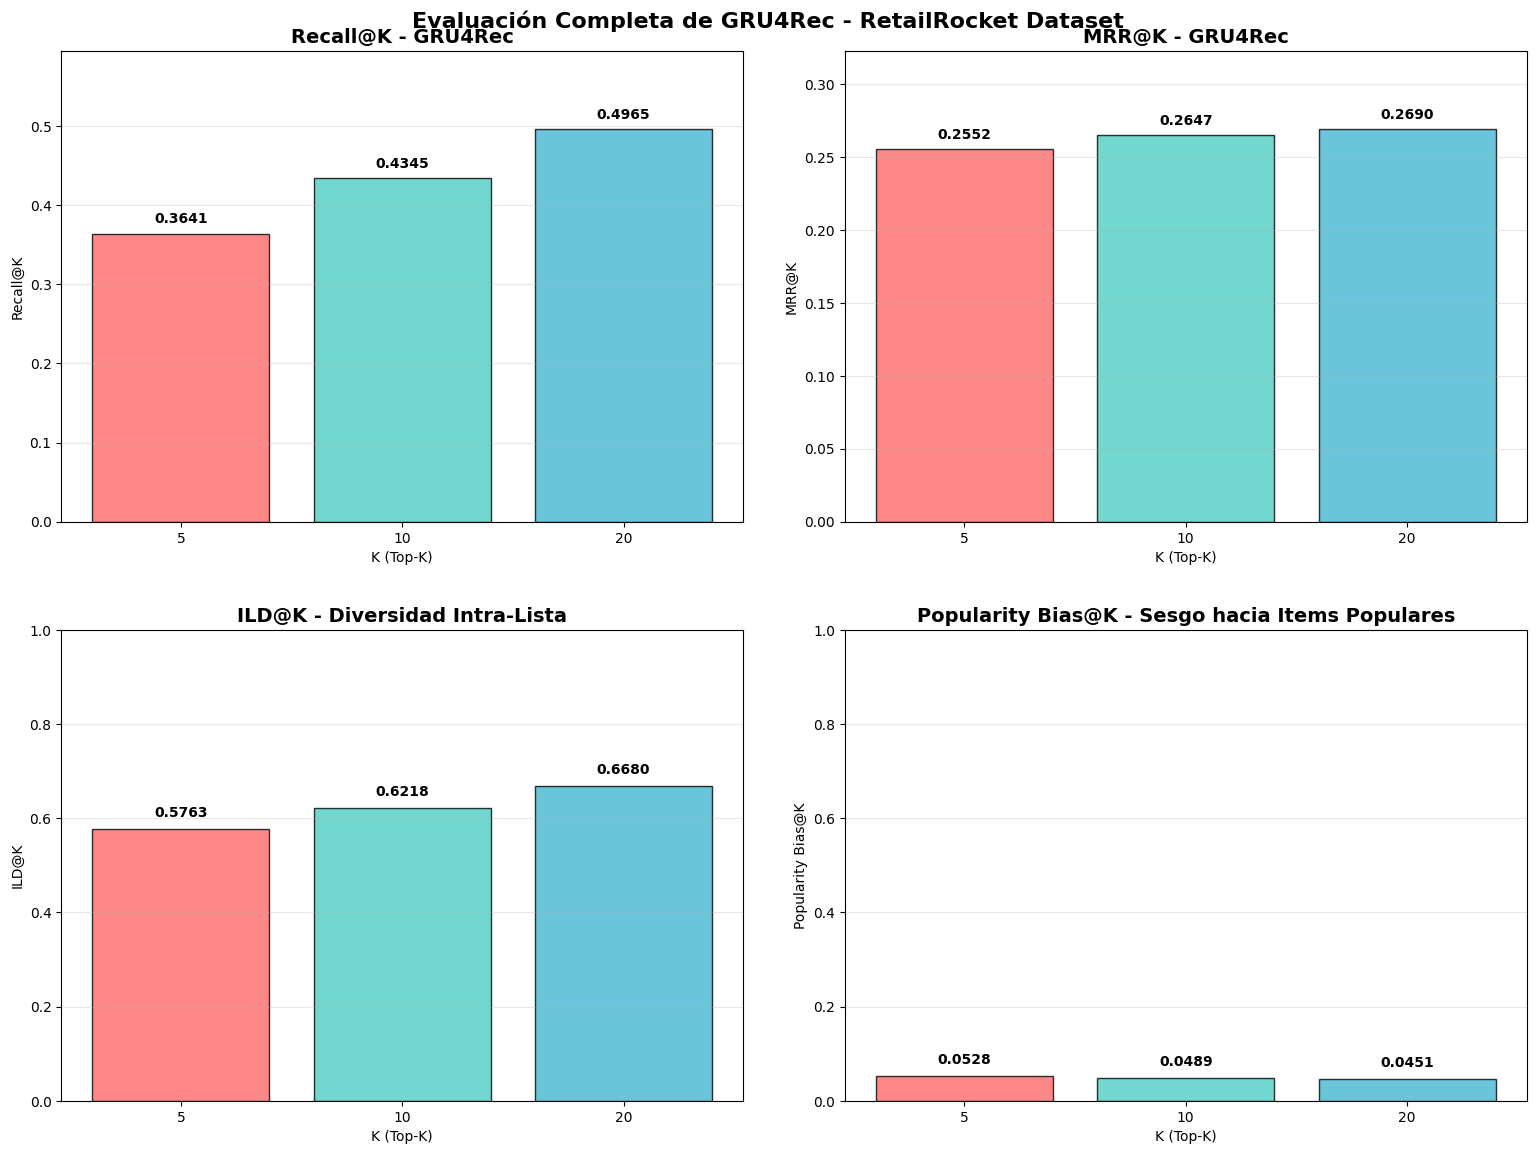


📋 TABLA DE RESUMEN - GRU4REC RETAILROCKET
Métrica              K=5          K=10         K=20        
------------------------------------------------------------
Recall               0.3641       0.4345       0.4965      
MRR                  0.2552       0.2647       0.2690      
ILD                  0.5763       0.6218       0.6680      
Popularity Bias      0.0528       0.0489       0.0451      

📈 ANÁLISIS DE TENDENCIAS - GRU4REC:
   🎯 Recall: Mejora al aumentar K
   📊 MRR: Mejora al aumentar K
   🌈 ILD: Mejora al aumentar K
   ⭐ Pop. Bias: Disminuye al aumentar K


In [9]:
# VISUALIZACIÓN COMPLETA
def create_comprehensive_visualization_gru4rec(results):
    """Crea visualizaciones completas de las métricas de GRU4Rec"""

    # Configurar estilo
    plt.style.use('default')
    sns.set_palette("husl")

    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    k_values = [5, 10, 20]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. Recall@K
    recall_values = [results[f'recall_{k}'] for k in k_values]
    bars1 = ax1.bar([str(k) for k in k_values], recall_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Recall@K - GRU4Rec', fontsize=14, fontweight='bold')
    ax1.set_xlabel('K (Top-K)')
    ax1.set_ylabel('Recall@K')
    ax1.set_ylim(0, max(recall_values) * 1.2)
    ax1.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars1, recall_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 2. MRR@K
    mrr_values = [results[f'mrr_{k}'] for k in k_values]
    bars2 = ax2.bar([str(k) for k in k_values], mrr_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('MRR@K - GRU4Rec', fontsize=14, fontweight='bold')
    ax2.set_xlabel('K (Top-K)')
    ax2.set_ylabel('MRR@K')
    ax2.set_ylim(0, max(mrr_values) * 1.2)
    ax2.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars2, mrr_values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mrr_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 3. ILD@K (Diversidad)
    ild_values = [results[f'ild_{k}'] for k in k_values]
    bars3 = ax3.bar([str(k) for k in k_values], ild_values, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_title('ILD@K - Diversidad Intra-Lista', fontsize=14, fontweight='bold')
    ax3.set_xlabel('K (Top-K)')
    ax3.set_ylabel('ILD@K')
    ax3.set_ylim(0, 1.0)  # ILD está entre 0 y 1
    ax3.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars3, ild_values)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 4. Popularity Bias@K
    pop_bias_values = [results[f'popularity_bias_{k}'] for k in k_values]
    bars4 = ax4.bar([str(k) for k in k_values], pop_bias_values, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Popularity Bias@K - Sesgo hacia Items Populares', fontsize=14, fontweight='bold')
    ax4.set_xlabel('K (Top-K)')
    ax4.set_ylabel('Popularity Bias@K')
    ax4.set_ylim(0, 1.0)  # Bias está entre 0 y 1
    ax4.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars4, pop_bias_values)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # Ajustar layout
    plt.tight_layout(pad=3.0)

    # Agregar título general
    fig.suptitle('Evaluación Completa de GRU4Rec - RetailRocket Dataset',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

# Crear visualizaciones de GRU4Rec
create_comprehensive_visualization_gru4rec(results)

# Crear tabla de resumen
print("\n📋 TABLA DE RESUMEN - GRU4REC RETAILROCKET")
print("="*60)
print(f"{'Métrica':<20} {'K=5':<12} {'K=10':<12} {'K=20':<12}")
print("-" * 60)
print(f"{'Recall':<20} {results['recall_5']:<12.4f} {results['recall_10']:<12.4f} {results['recall_20']:<12.4f}")
print(f"{'MRR':<20} {results['mrr_5']:<12.4f} {results['mrr_10']:<12.4f} {results['mrr_20']:<12.4f}")
print(f"{'ILD':<20} {results['ild_5']:<12.4f} {results['ild_10']:<12.4f} {results['ild_20']:<12.4f}")
print(f"{'Popularity Bias':<20} {results['popularity_bias_5']:<12.4f} {results['popularity_bias_10']:<12.4f} {results['popularity_bias_20']:<12.4f}")
print("="*60)

# Análisis de tendencias
print(f"\n📈 ANÁLISIS DE TENDENCIAS - GRU4REC:")
print(f"   🎯 Recall: {'Mejora' if results['recall_20'] > results['recall_5'] else 'Se mantiene'} al aumentar K")
print(f"   📊 MRR: {'Mejora' if results['mrr_20'] > results['mrr_5'] else 'Disminuye'} al aumentar K")
print(f"   🌈 ILD: {'Mejora' if results['ild_20'] > results['ild_5'] else 'Disminuye'} al aumentar K")
print(f"   ⭐ Pop. Bias: {'Aumenta' if results['popularity_bias_20'] > results['popularity_bias_5'] else 'Disminuye'} al aumentar K")


## 🔬 Análisis de Sensibilidad - Embedding Dimension (GRU4Rec)

**Objetivo**: Evaluar cómo la dimensión del embedding afecta el rendimiento (Recall@20) de GRU4Rec.

Este análisis nos permitirá encontrar la dimensión óptima para modelos recurrentes.

In [12]:
def evaluate_recall_at_k_only_gru4rec(model, test_loader, device, k=20):
    """
    Evaluación rápida que solo calcula Recall@K para análisis de sensibilidad GRU4Rec
    """
    model.eval()

    recall_hits = 0
    total_predictions = 0

    with torch.no_grad():
        for input_seq, target_seq in tqdm(test_loader, desc=f"Evaluando Recall@{k}"):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # Predicciones del modelo
            logits = model(input_seq)  # (batch_size, seq_len, vocab_size)

            # Máscara para posiciones válidas (no padding)
            mask = target_seq != 0

            # Procesar cada secuencia en el batch
            for i in range(logits.size(0)):
                seq_logits = logits[i]  # (seq_len, vocab_size)
                seq_targets = target_seq[i]  # (seq_len,)
                seq_mask = mask[i]  # (seq_len,)

                # Procesar cada posición en la secuencia
                for j in range(seq_logits.size(0)):
                    if seq_mask[j]:  # Si no es padding
                        pred_scores = seq_logits[j]  # (vocab_size,)
                        true_item = seq_targets[j].item()

                        # Obtener top-k items (excluyendo padding idx=0)
                        valid_scores = pred_scores[1:]  # Excluir padding (índice 0)
                        _, top_k_indices = torch.topk(valid_scores, k)
                        top_k_items = (top_k_indices + 1).cpu().tolist()  # +1 porque excluimos índice 0

                        # Calcular Recall@k
                        if true_item in top_k_items:
                            recall_hits += 1

                        total_predictions += 1

            # Limpieza periódica de memoria
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

    recall_k = recall_hits / total_predictions if total_predictions > 0 else 0.0
    return recall_k

def sensitivity_analysis_embedding_gru4rec(train_loader, test_loader, vocab_size, device,
                                          embedding_dims=[32, 64, 128, 256], epochs=5):
    """
    Análisis de sensibilidad del embedding dimension para GRU4Rec
    """
    print("🔬 INICIANDO ANÁLISIS DE SENSIBILIDAD - EMBEDDING DIMENSION (GRU4REC)")
    print(f"   Dimensiones a probar: {embedding_dims}")
    print(f"   Epochs por modelo: {epochs} (reducido para eficiencia)")
    print(f"   Métrica: Recall@20")

    results = {}
    training_times = {}
    model_sizes = {}

    for embed_dim in embedding_dims:
        print(f"\n🎯 Probando Embedding Dimension = {embed_dim}")

        # Crear modelo GRU4Rec con nueva dimensión
        model_test = GRU4Rec(
            num_items=vocab_size,
            embedding_dim=embed_dim,  # Variable dimension
            hidden_dim=128,           # Mantener hidden_dim constante
            num_layers=1,
            dropout=0.1
        ).to(device)

        # Contar parámetros
        total_params = sum(p.numel() for p in model_test.parameters())
        model_sizes[embed_dim] = total_params
        print(f"   Parámetros: {total_params:,}")

        # Entrenar modelo (epochs reducidos para eficiencia)
        start_time = time.time()

        optimizer = torch.optim.Adam(model_test.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss(ignore_index=0)

        model_test.train()
        for epoch in range(epochs):
            total_loss = 0.0
            num_batches = 0

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (dim={embed_dim})")

            for batch_idx, (input_seq, target_seq) in enumerate(progress_bar):
                input_seq = input_seq.to(device)
                target_seq = target_seq.to(device)

                optimizer.zero_grad()
                logits = model_test(input_seq)

                # Reshape for loss calculation
                logits = logits.reshape(-1, logits.size(-1))
                target_seq = target_seq.reshape(-1)

                loss = criterion(logits, target_seq)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model_test.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

                # Limpieza de memoria cada 50 batches
                if batch_idx % 50 == 0:
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None

            avg_loss = total_loss / num_batches
            print(f"   Epoch {epoch+1} completado - Loss: {avg_loss:.4f}")

            # Limpieza de memoria al final del epoch
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        training_time = time.time() - start_time
        training_times[embed_dim] = training_time
        print(f"   Tiempo de entrenamiento: {training_time:.2f} segundos")

        # Evaluar solo Recall@20
        print(f"   Evaluando Recall@20...")
        recall_20 = evaluate_recall_at_k_only_gru4rec(model_test, test_loader, device, k=20)
        results[embed_dim] = recall_20

        print(f"   ✅ Embedding Dim {embed_dim}: Recall@20 = {recall_20:.4f}")

        # Limpiar modelo de memoria
        del model_test
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results, training_times, model_sizes

# Ejecutar análisis de sensibilidad para GRU4Rec
print("🚀 Iniciando análisis de sensibilidad del embedding dimension para GRU4Rec...")

sensitivity_results_gru, training_times_gru, model_sizes_gru = sensitivity_analysis_embedding_gru4rec(
    train_loader=train_loader,
    test_loader=test_loader,
    vocab_size=VOCAB_SIZE,
    device=device,
    embedding_dims=[32, 64, 128, 256],
    epochs=5  # Reducido para eficiencia
)

print(f"\n📊 RESULTADOS DEL ANÁLISIS DE SENSIBILIDAD - GRU4REC:")
print(f"{'Embedding Dim':<15} {'Recall@20':<12} {'Parámetros':<12} {'Tiempo (s)':<12}")
print("-" * 55)
for dim in [32, 64, 128, 256]:
    print(f"{dim:<15} {sensitivity_results_gru[dim]:<12.4f} {model_sizes_gru[dim]:<12,} {training_times_gru[dim]:<12.1f}")
print("-" * 55)


🚀 Iniciando análisis de sensibilidad del embedding dimension para GRU4Rec...
🔬 INICIANDO ANÁLISIS DE SENSIBILIDAD - EMBEDDING DIMENSION (GRU4REC)
   Dimensiones a probar: [32, 64, 128, 256]
   Epochs por modelo: 5 (reducido para eficiencia)
   Métrica: Recall@20

🎯 Probando Embedding Dimension = 32
   Parámetros: 7,149,911


Epoch 1/5 (dim=32): 100%|██████████| 3844/3844 [00:54<00:00, 70.65it/s, Loss=10.0849]


   Epoch 1 completado - Loss: 9.9750


Epoch 2/5 (dim=32): 100%|██████████| 3844/3844 [00:50<00:00, 75.77it/s, Loss=7.8051]


   Epoch 2 completado - Loss: 8.7607


Epoch 3/5 (dim=32): 100%|██████████| 3844/3844 [00:50<00:00, 76.21it/s, Loss=7.2806]


   Epoch 3 completado - Loss: 7.3947


Epoch 4/5 (dim=32): 100%|██████████| 3844/3844 [00:50<00:00, 76.26it/s, Loss=7.8005]


   Epoch 4 completado - Loss: 6.3102


Epoch 5/5 (dim=32): 100%|██████████| 3844/3844 [00:50<00:00, 76.69it/s, Loss=6.6844]


   Epoch 5 completado - Loss: 5.4920
   Tiempo de entrenamiento: 257.40 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 961/961 [00:33<00:00, 28.28it/s]


   ✅ Embedding Dim 32: Recall@20 = 0.4260

🎯 Probando Embedding Dimension = 64
   Parámetros: 8,570,935


Epoch 1/5 (dim=64): 100%|██████████| 3844/3844 [00:52<00:00, 72.86it/s, Loss=9.7536]


   Epoch 1 completado - Loss: 9.8498


Epoch 2/5 (dim=64): 100%|██████████| 3844/3844 [00:52<00:00, 73.89it/s, Loss=7.9074]


   Epoch 2 completado - Loss: 8.2539


Epoch 3/5 (dim=64): 100%|██████████| 3844/3844 [00:52<00:00, 73.33it/s, Loss=5.5601]


   Epoch 3 completado - Loss: 6.6959


Epoch 4/5 (dim=64): 100%|██████████| 3844/3844 [00:52<00:00, 73.33it/s, Loss=6.1894]


   Epoch 4 completado - Loss: 5.5814


Epoch 5/5 (dim=64): 100%|██████████| 3844/3844 [00:52<00:00, 73.47it/s, Loss=4.7473]


   Epoch 5 completado - Loss: 4.7939
   Tiempo de entrenamiento: 263.15 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 961/961 [00:34<00:00, 28.16it/s]


   ✅ Embedding Dim 64: Recall@20 = 0.4765

🎯 Probando Embedding Dimension = 128
   Parámetros: 11,412,983


Epoch 1/5 (dim=128): 100%|██████████| 3844/3844 [00:56<00:00, 67.44it/s, Loss=9.6198]


   Epoch 1 completado - Loss: 9.7339


Epoch 2/5 (dim=128): 100%|██████████| 3844/3844 [00:57<00:00, 67.18it/s, Loss=7.5194]


   Epoch 2 completado - Loss: 7.8170


Epoch 3/5 (dim=128): 100%|██████████| 3844/3844 [00:57<00:00, 67.03it/s, Loss=5.4729]


   Epoch 3 completado - Loss: 6.1008


Epoch 4/5 (dim=128): 100%|██████████| 3844/3844 [00:57<00:00, 67.01it/s, Loss=4.7397]


   Epoch 4 completado - Loss: 4.9639


Epoch 5/5 (dim=128): 100%|██████████| 3844/3844 [00:57<00:00, 66.95it/s, Loss=5.1992]


   Epoch 5 completado - Loss: 4.2057
   Tiempo de entrenamiento: 287.59 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 961/961 [00:34<00:00, 27.78it/s]


   ✅ Embedding Dim 128: Recall@20 = 0.5090

🎯 Probando Embedding Dimension = 256
   Parámetros: 17,097,079


Epoch 1/5 (dim=256): 100%|██████████| 3844/3844 [01:05<00:00, 58.82it/s, Loss=9.0356]


   Epoch 1 completado - Loss: 9.5773


Epoch 2/5 (dim=256): 100%|██████████| 3844/3844 [01:05<00:00, 58.64it/s, Loss=6.2155]


   Epoch 2 completado - Loss: 7.2534


Epoch 3/5 (dim=256): 100%|██████████| 3844/3844 [01:05<00:00, 58.68it/s, Loss=5.6640]


   Epoch 3 completado - Loss: 5.4915


Epoch 4/5 (dim=256): 100%|██████████| 3844/3844 [01:05<00:00, 58.41it/s, Loss=4.7380]


   Epoch 4 completado - Loss: 4.4478


Epoch 5/5 (dim=256): 100%|██████████| 3844/3844 [01:06<00:00, 58.24it/s, Loss=4.2341]


   Epoch 5 completado - Loss: 3.7790
   Tiempo de entrenamiento: 329.38 segundos
   Evaluando Recall@20...


Evaluando Recall@20: 100%|██████████| 961/961 [00:35<00:00, 26.95it/s]


   ✅ Embedding Dim 256: Recall@20 = 0.5238

📊 RESULTADOS DEL ANÁLISIS DE SENSIBILIDAD - GRU4REC:
Embedding Dim   Recall@20    Parámetros   Tiempo (s)  
-------------------------------------------------------
32              0.4260       7,149,911    257.4       
64              0.4765       8,570,935    263.2       
128             0.5090       11,412,983   287.6       
256             0.5238       17,097,079   329.4       
-------------------------------------------------------



📊 Creando visualizaciones del análisis de sensibilidad GRU4Rec...


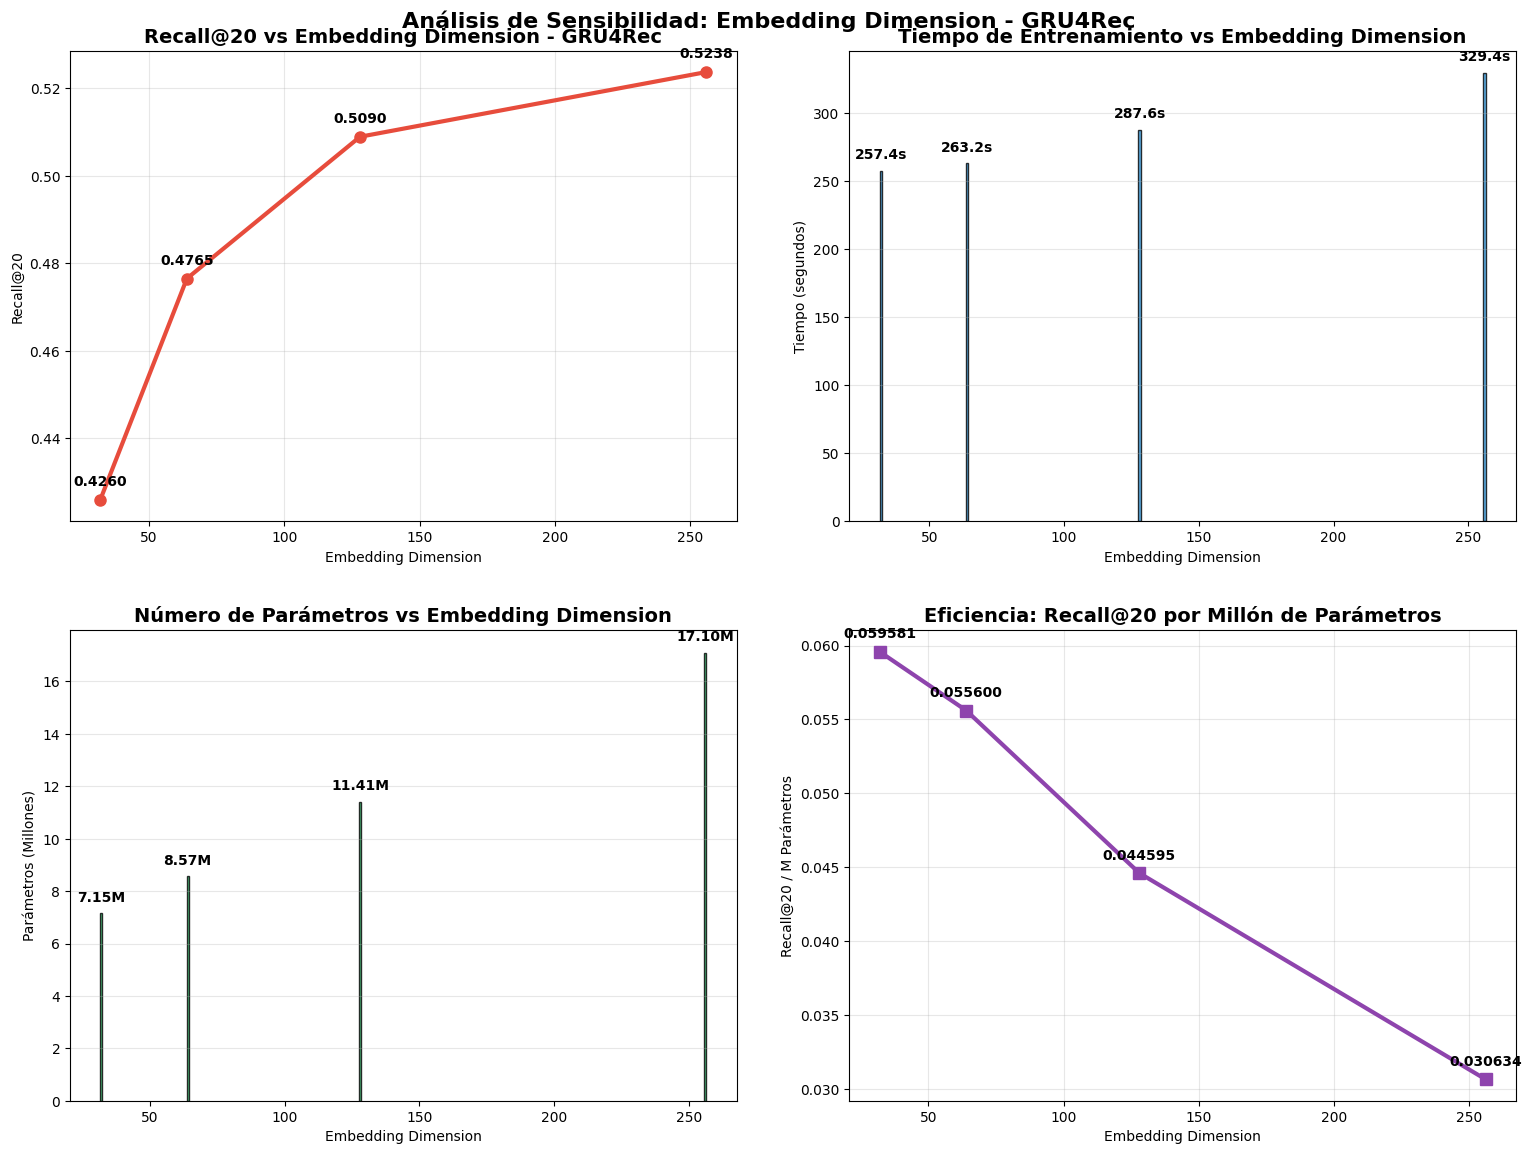


📈 ANÁLISIS ESTADÍSTICO - GRU4REC:
   🎯 Mejor Recall@20: Dimension 256 = 0.5238
   ⚡ Mejor Eficiencia: Dimension 32 = 0.059581
   📊 Mejora de 32→256: 22.9%
   💾 Costo de parámetros 32→256: 2.4x más parámetros

💾 Análisis de sensibilidad de GRU4Rec guardado en 'gru4rec_sensitivity_analysis.json'

🔄 SENSIBILIDAD AL EMBEDDING DIMENSION

📊 TABLA COMPARATIVA:
Embedding Dim   GRU4Rec     
----------------------------------------------------------------------
32              0.4260      
64              0.4765      
128             0.5090      
256             0.5238      
----------------------------------------------------------------------


In [13]:
# VISUALIZACIÓN DEL ANÁLISIS DE SENSIBILIDAD - GRU4REC
def create_sensitivity_visualization_gru4rec(sensitivity_results, training_times, model_sizes):
    """Crea visualizaciones del análisis de sensibilidad de embedding dimension para GRU4Rec"""

    embedding_dims = list(sensitivity_results.keys())
    recall_values = list(sensitivity_results.values())
    time_values = list(training_times.values())
    param_values = list(model_sizes.values())

    # Crear figura con múltiples subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Recall@20 vs Embedding Dimension
    ax1.plot(embedding_dims, recall_values, 'o-', linewidth=3, markersize=8, color='#E74C3C')
    ax1.set_title('Recall@20 vs Embedding Dimension - GRU4Rec', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Embedding Dimension')
    ax1.set_ylabel('Recall@20')
    ax1.grid(True, alpha=0.3)

    # Anotar valores
    for dim, recall in zip(embedding_dims, recall_values):
        ax1.annotate(f'{recall:.4f}', (dim, recall), textcoords="offset points",
                    xytext=(0,10), ha='center', fontweight='bold')

    # 2. Tiempo de Entrenamiento vs Embedding Dimension
    ax2.bar(embedding_dims, time_values, color='#3498DB', alpha=0.8, edgecolor='black')
    ax2.set_title('Tiempo de Entrenamiento vs Embedding Dimension', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Embedding Dimension')
    ax2.set_ylabel('Tiempo (segundos)')
    ax2.grid(True, alpha=0.3, axis='y')

    # Anotar valores
    for dim, time_val in zip(embedding_dims, time_values):
        ax2.text(dim, time_val + max(time_values) * 0.02, f'{time_val:.1f}s',
                ha='center', va='bottom', fontweight='bold')

    # 3. Número de Parámetros vs Embedding Dimension
    param_millions = [p/1e6 for p in param_values]
    ax3.bar(embedding_dims, param_millions, color='#27AE60', alpha=0.8, edgecolor='black')
    ax3.set_title('Número de Parámetros vs Embedding Dimension', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Embedding Dimension')
    ax3.set_ylabel('Parámetros (Millones)')
    ax3.grid(True, alpha=0.3, axis='y')

    # Anotar valores
    for dim, param_m in zip(embedding_dims, param_millions):
        ax3.text(dim, param_m + max(param_millions) * 0.02, f'{param_m:.2f}M',
                ha='center', va='bottom', fontweight='bold')

    # 4. Eficiencia: Recall@20 / Parámetros
    efficiency = [r/p*1e6 for r, p in zip(recall_values, param_values)]
    ax4.plot(embedding_dims, efficiency, 's-', linewidth=3, markersize=8, color='#8E44AD')
    ax4.set_title('Eficiencia: Recall@20 por Millón de Parámetros', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Embedding Dimension')
    ax4.set_ylabel('Recall@20 / M Parámetros')
    ax4.grid(True, alpha=0.3)

    # Anotar valores
    for dim, eff in zip(embedding_dims, efficiency):
        ax4.annotate(f'{eff:.6f}', (dim, eff), textcoords="offset points",
                    xytext=(0,10), ha='center', fontweight='bold')

    plt.tight_layout(pad=3.0)

    # Agregar título general
    fig.suptitle('Análisis de Sensibilidad: Embedding Dimension - GRU4Rec',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

    # Análisis estadístico
    best_recall_dim = max(sensitivity_results, key=sensitivity_results.get)
    best_efficiency_dim = embedding_dims[efficiency.index(max(efficiency))]

    print(f"\n📈 ANÁLISIS ESTADÍSTICO - GRU4REC:")
    print(f"   🎯 Mejor Recall@20: Dimension {best_recall_dim} = {sensitivity_results[best_recall_dim]:.4f}")
    print(f"   ⚡ Mejor Eficiencia: Dimension {best_efficiency_dim} = {max(efficiency):.6f}")
    print(f"   📊 Mejora de 32→256: {((sensitivity_results[256]/sensitivity_results[32])-1)*100:.1f}%")
    print(f"   💾 Costo de parámetros 32→256: {(model_sizes[256]/model_sizes[32]):.1f}x más parámetros")

    return {
        'best_recall_dim': best_recall_dim,
        'best_efficiency_dim': best_efficiency_dim,
        'efficiency_scores': efficiency
    }

# Crear visualizaciones de GRU4Rec
print("\n📊 Creando visualizaciones del análisis de sensibilidad GRU4Rec...")
sensitivity_analysis_gru = create_sensitivity_visualization_gru4rec(
    sensitivity_results_gru, training_times_gru, model_sizes_gru
)

# Guardar resultados del análisis de sensibilidad de GRU4Rec
sensitivity_data_gru = {
    'embedding_dimensions': [32, 64, 128, 256],
    'recall_20_scores': sensitivity_results_gru,
    'training_times': training_times_gru,
    'model_sizes': model_sizes_gru,
    'analysis': sensitivity_analysis_gru
}

import json
with open('../outputs/GRU4Rec_RetailRocket/gru4rec_rr_sensitivity_analysis.json', 'w') as f:
    json.dump(sensitivity_data_gru, f, indent=2)

print(f"\n💾 Análisis de sensibilidad de GRU4Rec guardado en 'gru4rec_sensitivity_analysis.json'")

print(f"\n" + "="*80)
print("🔄 SENSIBILIDAD AL EMBEDDING DIMENSION")
print("="*80)

print(f"\n📊 TABLA COMPARATIVA:")
print(f"{'Embedding Dim':<15} {'GRU4Rec':<12}")
print("-" * 70)

for dim in [32, 64, 128, 256]:
    gru_score = sensitivity_results_gru[dim]

    print(f"{dim:<15} {gru_score:<12.4f}")

print("-" * 70)